# **Taller 1**

Métodos y Aplicaciones de Analítica II

**Nombres:** María Fernanda Izquierdo Aparicio & Erica Marcela Martinez Silva

**Fecha:** 16 de Marzo de 2024

**Instrucciones del Taller**
* Realizar un programa que realice una transformación automática de las variables.
* Realizar un EDA (mucho más rico que el visto en clase)
* Entrene mínimo tres modelos (incluido el SVM), realice el auto tuning de los hiperparametros y seleccione el mejor modelo.
* Finalmente el programa debe crear un archivo con el modelo seleccionado que se pueda exportar (se debe investigar sobre esta funcionalidad usando sklearn).
* El programa debe evitar repetir código, estar buen estructurado y documentado, por lo cual deben usar clases.
* Se debe realizar una gráfica en la que se muestren dos métricas de desempeño de clasificación y el cambio de los hiperparametros C y kernel para el SVM.
* Agregar y comparar dos nuevos métodos de ML, Random Forest y Adaboost.

## **1. Instalación de librerias e importe de datos**

In [1]:
# Importar librerias:
import pandas as pd
import numpy as np
import seaborn as sns # hacer matriz de correlación

from datetime import datetime, timedelta # Para hacer cambios en fechas (datatype)

!pip install pandas dataprep # Dataprep para hacer EDA
from dataprep.eda import create_report

from imblearn.over_sampling import RandomOverSampler # Para realizar oversampling (balanceo)
from collections import Counter

import matplotlib.pyplot as plt # Graficar

from sklearn.impute import SimpleImputer # imputación de datos para valores missing
from sklearn.model_selection import train_test_split # seleccionar mejor medelo separando train & test
from sklearn.model_selection import GridSearchCV #fine tuning de hiperparámetros
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer # metrícas de desempeño

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importar datos a utilizar
path = "03 CSV data -- STC(A)_numerical dates.csv"
df = pd.read_csv(path, header = 0)

# Entender que tipo de variables tenemos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              2389 non-null   int64  
 1   Program.Code                    2389 non-null   object 
 2   From.Grade                      2262 non-null   float64
 3   To.Grade                        2239 non-null   float64
 4   Group.State                     2389 non-null   object 
 5   Is.Non.Annual.                  2389 non-null   int64  
 6   Days                            2389 non-null   int64  
 7   Travel.Type                     2389 non-null   object 
 8   Departure.Date                  2389 non-null   int64  
 9   Return.Date                     2389 non-null   int64  
 10  Deposit.Date                    2389 non-null   int64  
 11  Special.Pay                     470 non-null    object 
 12  Tuition                         23

## **2. Realización del EDA**

### 2.1. Exploración de la data

In [3]:
# Generar el reporte exploratorio utilizando la función create_report de dataprep
reporte_df = create_report(df)

# Guardar el reporte en un archivo HTML
reporte_df.save('reporte_df.html')
print("Reporte exploratorio generado y guardado en reporte_df.html.")

ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'DifferenceTra...ing'
ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'DifferenceTra...ing'
ERROR:bokeh.core.validation.check:E-1019 (DUPLICATE_FACTORS): FactorRange must specify a unique list of categorical factors for an axis: duplicate factors found: 'DifferenceTra...ing'


Report has been saved to reporte_df.html!
Reporte exploratorio generado y guardado en reporte_df.html.


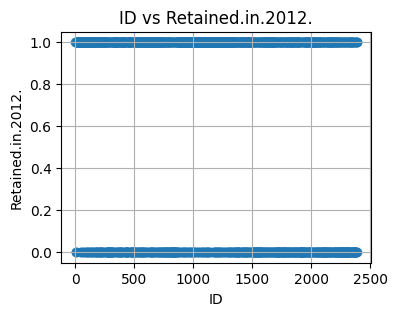

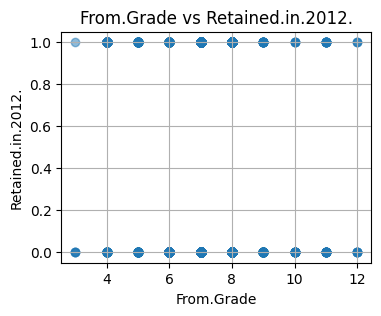

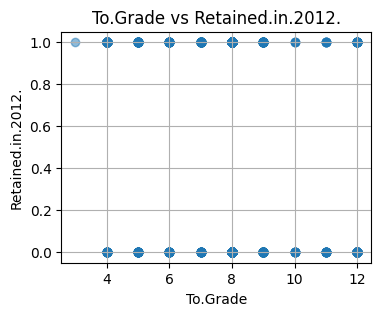

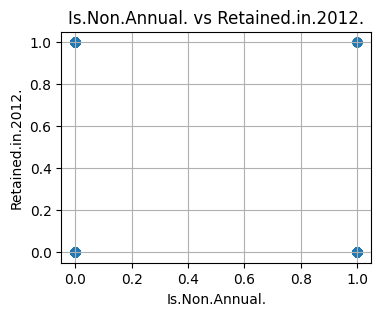

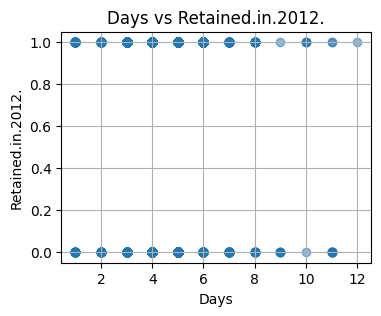

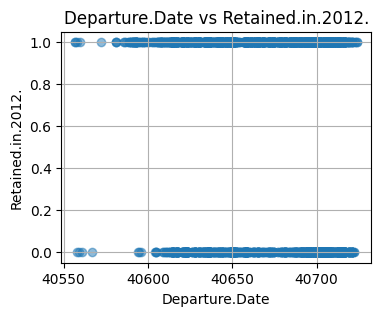

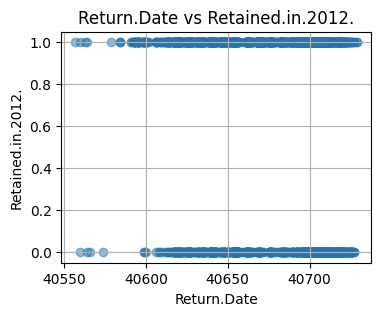

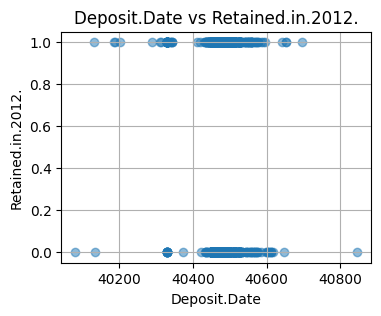

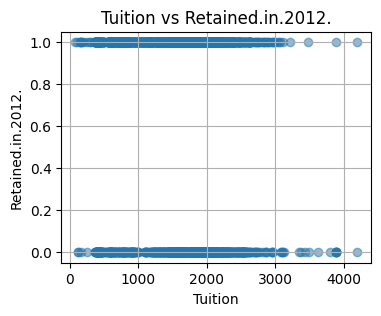

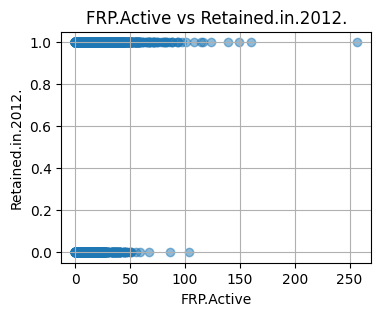

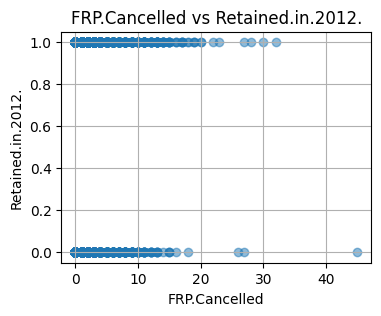

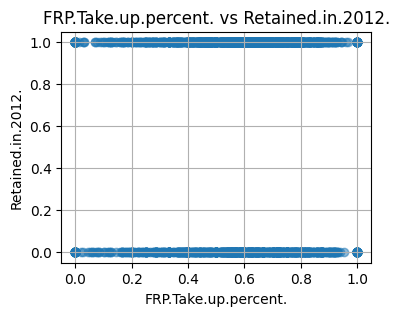

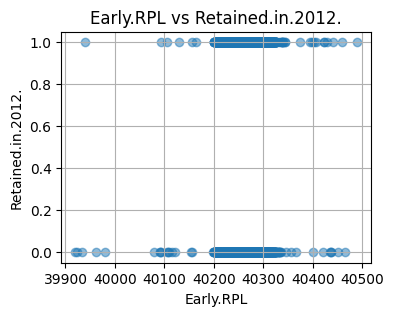

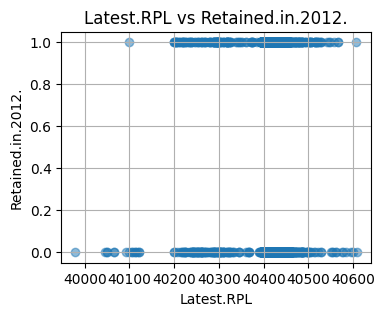

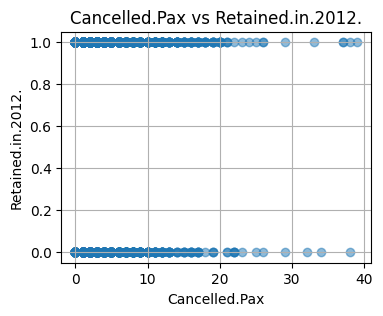

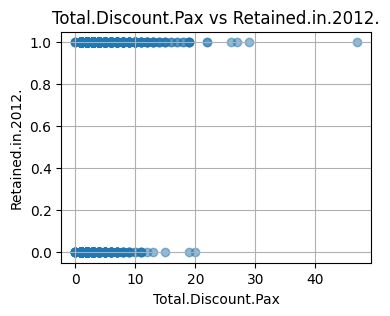

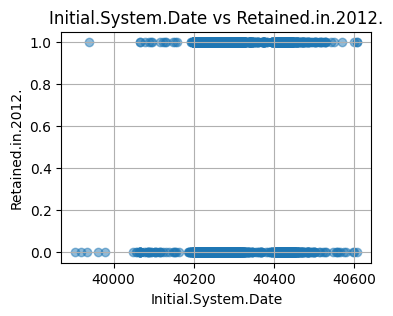

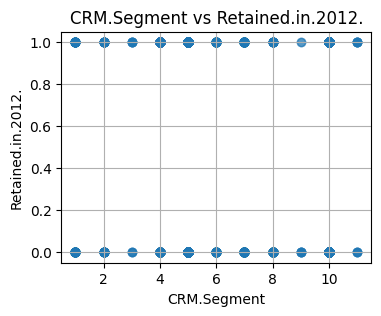

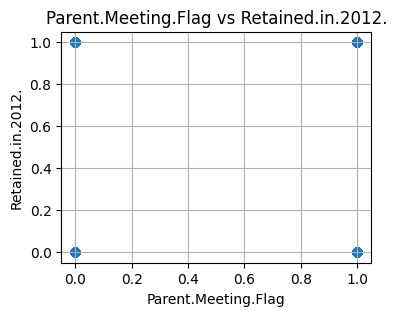

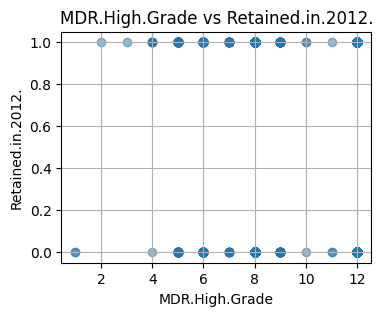

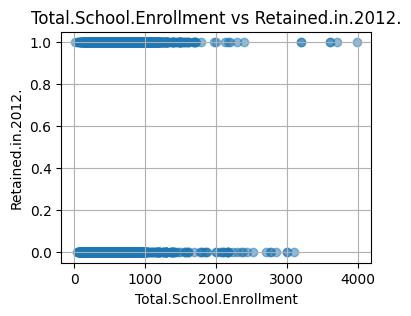

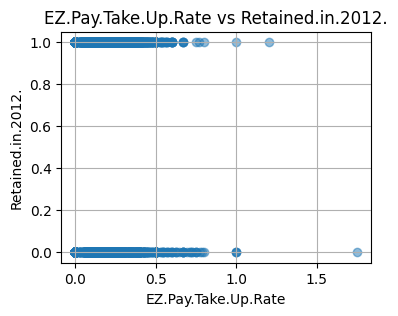

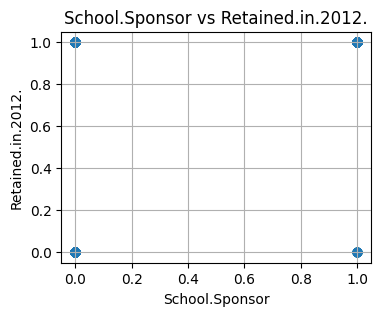

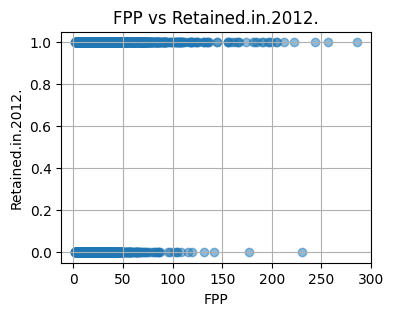

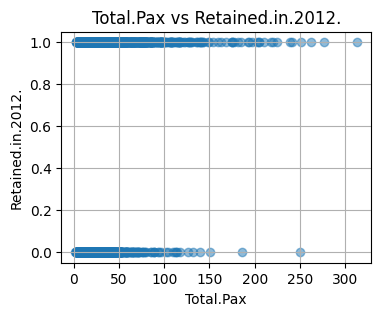

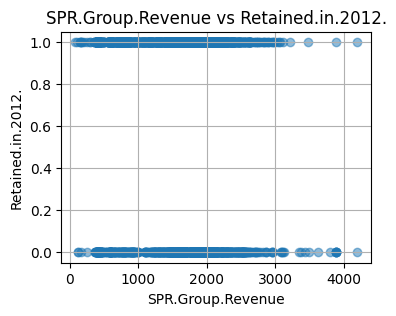

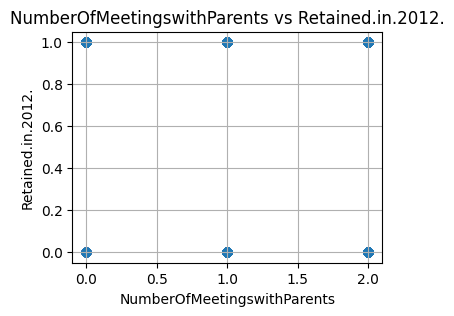

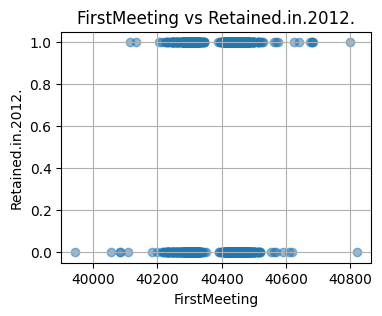

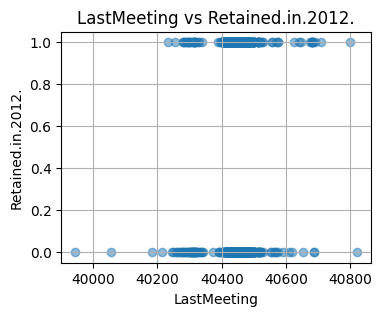

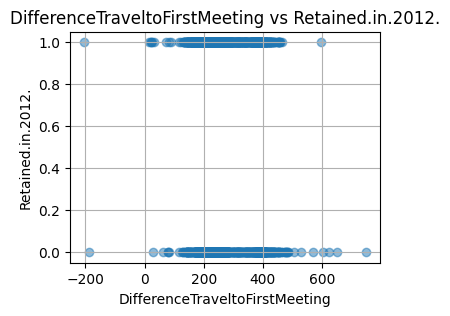

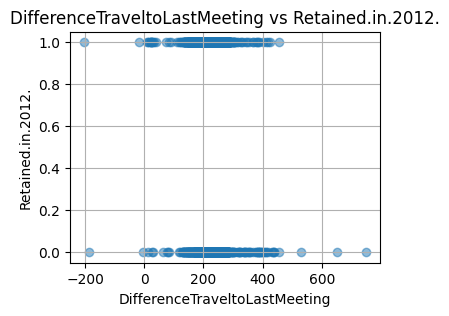

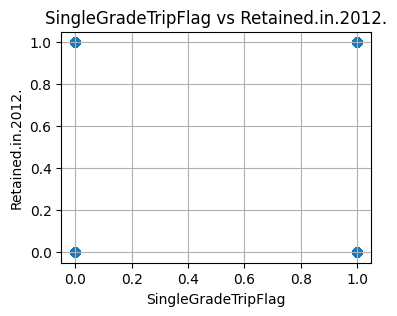

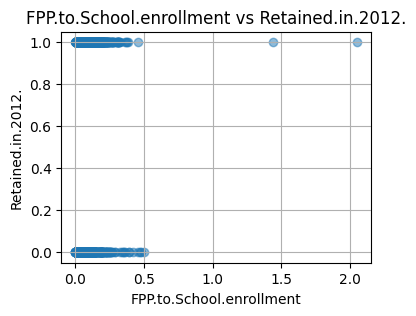

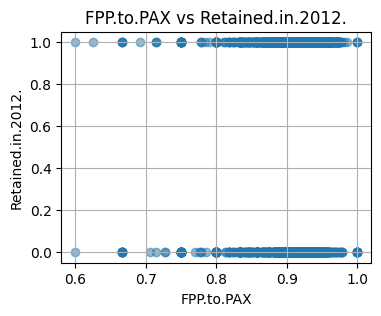

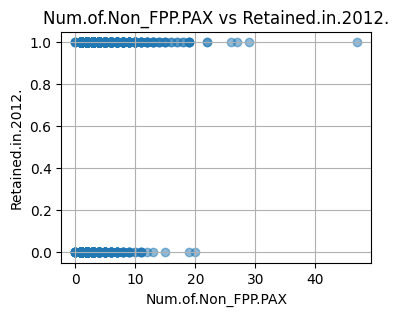

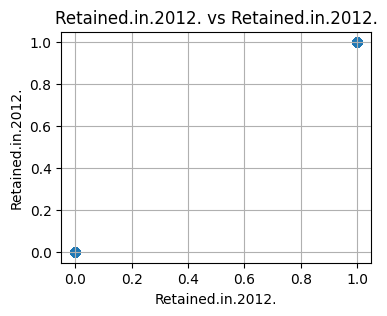

In [4]:
# Generar Scatterplots con respecto a la variable objetivo: 'Retained.in.2012.'
def scatter_plot_numeric_variables(df, target_variable):
    numeric_columns = df.select_dtypes(include=['int', 'float']).columns

    for column in numeric_columns:
        plt.figure(figsize=(4, 3))
        plt.scatter(df[column], df[target_variable], alpha=0.5)
        plt.title(f'{column} vs {target_variable}')
        plt.xlabel(column)
        plt.ylabel(target_variable)
        plt.grid(True)
        plt.show()

scatter_plot_numeric_variables(df, 'Retained.in.2012.')

#### **Principales hallazgos del EDA**

*   ID es un único identificador para cada registro, por lo cual se puede remover del preprocesamiento de datos.

*   Hay varias variables con porcentaje de missing values, por lo que es importante reemplazar o imputar datos:
  > * From.Grade 5% de missing values
  > * To.Grade 6% de missing values
  > * Special.Pay 80% de missing values
  > * Early.RPL 28% de missing values
  > * Latest.RPL 1% de missing values
  > * Poverty.Code 25% de missing values
  > * MDR.Low.Grade 3% de missing values
  > * MDR.High.Grade 3% de missing values
  > * Total.School.Enrollment 4% de missing values
  > * Income.Level 3% de missing values
  > * FirstMeeting 14% de missing values
  > * LastMeeting 14% de missing values
  > * DifferenceTraveltoFirstMeeting 14% de missing values
  > * DifferenceTraveltoLastMeeting 14% de missing values
  > * FPP.to.School.enrollment 4% de missing values
  > * SchoolSizeIndicator 4% de missing values

*  De las variables numéricas que se tienen, hay algunas que presentan sesgos significativos:
  > * Departure.Date tiene sesgo negativo con un coeficiente de -0.5142 y los datos son asimétricos con un sesgo a la derecha.
  > * Return.Date tiene sesgo negativo con un coeficiente de -0.5001 y los datos son asimétricos con un sesgo a la derecha.
  > * Deposit.Date tiene sesgo negativo con un coeficiente de -1.8452 y los datos son asimétricos con un sesgo a la derecha.
  > * Tuition tiene ligero sesgo negativo con un coeficiente de -0.1277 y los datos son  asimétricos con un leve sesgo a la derecha.
  > * FRP.Active tiene un sesgo positivo con un coeficiente de 3.3214 y los datos son asimétricos con sesgo a la izquierda.
  > * FRP.Cancelled tiene un sesgo positivo con un coeficiente de 2.6715 y los datos son asimétricos con sesgo a la izquierda.
  > * FRP.Take.up.percent tiene un sesgo negativo con un coeficiente de -0.6966 y los datos son asimétricos con sesgo a la derecha.
  > * Early.RPL tiene un sesgo negativo con un coeficiente de -1.0064 y los datos son asimétricos con sesgo a la derecha.
  > * Latest.RPL tiene un sesgo negativo con un coeficiente de -2.4796 y los datos son asimétricos con sesgo a la derecha.
  > * Cancelled.Pax tiene un sesgo positivo con un coeficiente de 2.284 y los datos son asimétricos con sesgo a la izquierda.
  > * Total.Discount.Pax tiene un sesgo positivo con un coeficiente de 4.2272 y los datos son asimétricos con sesgo a la izquierda.
  > * Initial.System.Date tiene un leve sesgo positivo con un coeficiente de 0.499 y los datos son asimétricos con sesgo a la izquierda.
  > * Total.School.Enrollment tiene un sesgo positivo con un coeficiente de 2.2055 y los datos son asimétricos con sesgo a la izquierda.
  > * EZ.Pay.Take.Up.Rate tiene un sesgo positivo con un coeficiente de 1.2798 y los datos son asimétricos con sesgo a la izquierda.
  > * FPP tiene un sesgo positivo con un coeficiente de 2.8338 y los datos son asimétricos con sesgo a la izquierda.
  > * Total.Pax tiene un sesgo positivo con un coeficiente de 2.8839 y los datos son asimétricos con sesgo a la izquierda.
  > * SPR.Group.Revenue tiene un leve sesgo negativo con un coeficiente de -0.1277 y los datos son asimétricos con un sesgo a la derecha.
  > * FirstMeeting tiene un leve sesgo negativo con un coeficiente de -0.8839y los datos son asimétricos con un sesgo a la derecha.
  > * LastMeeting tiene un leve sesgo negativo con un coeficiente de -0.2855 y los datos son asimétricos con un sesgo a la derecha.
  > * DifferenceTraveltoLastMeeting
  > * FPP.to.School.enrollment
  > * FPP.to.PAX
  > * Num.of.Non_FPP.PAX

*  La variable de interés (Retained.in.2012.) no es una variable balanceada debido a que la distribución entre niveles no es 50%-50%. En este caso hay 1451 observaciones que tienen outcome = 1 lo que representa el 60.74% del total de las observaciones, y hay 938 observaciones con outcome = 0, que representan el 39.26% de la distribución.


### 2.2. Limpieza y trasformación de la data según lo encontrado en la exploración

#### Creación de grupos de estados usando la clasificación por regiones

In [5]:
# Diccionario que mapea estados a sus regiones
estados_a_regiones = {
    "AL": "South", "AK": "West", "AZ": "West", "AR": "South", "CA": "West",
    "CO": "West", "CT": "Northeast", "DE": "South", "FL": "South", "GA": "South",
    "HI": "West", "ID": "West", "IL": "Midwest", "IN": "Midwest", "IA": "Midwest",
    "KS": "Midwest", "KY": "South", "LA": "South", "ME": "Northeast", "MD": "South",
    "MA": "Northeast", "MI": "Midwest", "MN": "Midwest", "MS": "South", "MO": "Midwest",
    "MT": "West", "NE": "Midwest", "NV": "West", "NH": "Northeast", "NJ": "Northeast",
    "NM": "West", "NY": "Northeast", "NC": "South", "ND": "Midwest", "OH": "Midwest",
    "OK": "South", "OR": "West", "PA": "Northeast", "RI": "Northeast", "SC": "South",
    "SD": "Midwest", "TN": "South", "TX": "South", "UT": "West", "VT": "Northeast",
    "VA": "South", "WA": "West", "WV": "South", "WI": "Midwest", "WY": "West"
}

# Crear una nueva columna 'Región' basada en la columna 'Estado'
df['State_Region'] = df['Group.State'].map(estados_a_regiones)

# Quitamos la columna Group.State y guardarla en una nueva variable
Group_State_column = df.pop('Group.State')

# Mostrar el DataFrame con la nueva columna 'Region'
df.head()


,ID,Program.Code,From.Grade,To.Grade,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,...,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.,State_Region
0,1,HS,4.0,4.0,0,1,A,40557,40557,40420,...,Elementary,K->Elementary,H,1,0.063646,0.936508,4,L,1,West
1,2,HC,8.0,8.0,0,7,A,40557,40564,40132,...,Middle,Middle->Middle,H,1,0.025882,0.880000,3,L,1,West
2,3,HD,8.0,8.0,0,3,A,40558,40560,40466,...,Middle,Middle->Middle,H,1,0.025131,0.888889,3,L,1,South
3,4,HN,9.0,12.0,1,3,B,40558,40560,40550,...,Undefined,Undefined->Undefined,H,0,NaN,1.000000,0,NaN,0,South
4,5,HD,6.0,8.0,0,6,T,40559,40564,40451,...,Middle,Middle->Middle,H,0,0.112500,0.910112,8,M-L,0,South


#### Limpieza de datos (correlacion, eliminación de mising, one-hot coding) usando los archivos *Limpieza.py* y *Correlación.py*

In [6]:
# Importar del archivo Limpieza.py la clase DataCleaner
from Limpieza import DataCleaner

# Definir la fecha base de Excel
excel_base_date = datetime(1900, 1, 1)

# Crear una instancia de DataCleaner
cleaner = DataCleaner(excel_base_date)

# Limpiar el DataFrame
df = cleaner.clean(df)

In [7]:
# Remoción de columnas de fechas porque no corren con los modelos propuestos
Departure_Date_column = df.pop('Departure.Date')
Return_Date_column = df.pop('Return.Date')
Deposit_Date_column = df.pop('Deposit.Date')

In [8]:
# Revisamos el Dataframe
df.head()

,ID,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.School.Enrollment,FPP,SPR.Group.Revenue,DifferenceTraveltoFirstMeeting,FPP.to.School.enrollment,...,MajorProgramCode_S,SingleGradeTripFlag_1,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,SchoolSizeIndicator_missing_value,State_Region_Northeast,State_Region_South,State_Region_West,State_Region_missing_value
0,1.0,0.424,40266.0,40402.0,3.0,927.0,59.0,424.0,155.0,0.063646,...,0,1,0,0,0,0,0,0,1,0
1,2.0,0.409,40106.0,40400.0,11.0,850.0,22.0,2350.0,423.0,0.025882,...,0,1,0,0,0,0,0,0,1,0
2,3.0,0.708,40297.0,40406.0,6.0,955.0,24.0,1181.0,124.0,0.025131,...,0,1,0,0,0,0,0,1,0,0
3,4.0,0.000,40262.0,40417.0,1.0,597.0,18.0,376.0,250.0,0.045256,...,0,0,0,0,0,1,0,1,0,0
4,5.0,0.494,40266.0,40402.0,9.0,720.0,81.0,865.0,145.0,0.112500,...,0,0,1,0,0,0,0,1,0,0


## **3. Entrenamiento de modelos**

### 3.1. Fundamentales para los modelos:
- Generación de vectores X & y
- Generación de semilla
- División de los datos entre train y test
- Balanceo de y usando oversampling
- Creación de variable de media de Y
- Creación de clase para hacer Cross Validation

In [9]:
#Definir vectores de target (y) and matrix of features (X)
y = df['Retained.in.2012.']
X = df.drop(columns = 'Retained.in.2012.')

In [10]:
# Generación de semilla
seed = 123456
np.random.seed(seed)

# División de los datos aleatoriamente en 80% de entrenamiento y 20% de testeo con estratificación
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)

# Revisión de la división en entrenamiento y testeo
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1911, 197)
(478, 197)
(1911,)
(478,)


In [11]:
# Teniendo que X_train y y_train son nuestros datos de entrenamiento, X_train es una matriz de características y y_train es el vector de retención. Antes de aplicar el balanceo, verificamos el desequilibrio de clases
print("Conteo de clases antes del balanceo:", Counter(y_train))

# Instanciar el objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=seed)

# Aplicar el balanceo a los datos de entrenamiento
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Verificar el balance después del oversampling
print("Conteo de clases después del balanceo:", Counter(y_train_resampled))

Conteo de clases antes del balanceo: Counter({1.0: 1161, 0.0: 750})
Conteo de clases después del balanceo: Counter({1.0: 1161, 0.0: 1161})


In [12]:
# Remover la columna 'ID' de los dataframes de Train y Test, y la guardarmos en una nueva variable
#id_column_X_train = X_train.pop('ID')
#id_column_X_test = X_test.pop('ID')

In [13]:
mean_retention = df['Retained.in.2012.'].mean()
print(mean_retention)

0.6073670992046881


In [14]:
# Creación de la clase para Cross Validation
from sklearn.model_selection import cross_val_score

class CrossValidation:
    def __init__(self, model):
        self.model = model

    def validate(self, X, y, cv=5, scoring='accuracy'):
        scores = cross_val_score(self.model, X, y, cv=cv, scoring=scoring)
        return scores.mean(), scores.std()

### 3.2. Modelo 1 - SVM

#### Generación de Pipeline

In [15]:
# Almacenar los pasos del proceso de modelado de SVM.
svm_estimators = []

# Se agrega un paso llamado 'standardize' a la lista svm_estimators. Este paso utiliza StandardScaler() de scikit-learn para estandarizar (escalar)
# los datos, lo que es comúnmente recomendado antes de entrenar un modelo de SVM.

svm_estimators.append(('standardize', StandardScaler())) # scale the data

# Se agrega otro paso llamado 'SVM' a la lista svm_estimators. En este paso, se define el clasificador de SVM utilizando svm.SVC(probability=True).
# El argumento probability=True se usa para habilitar la predicción de probabilidades, lo cual no es habilitado por defecto en SVM.

svm_estimators.append(('SVM', svm.SVC(probability=True))) # define SVM with probabilities (recall, SVM be default does not predict probabilities)

# Se crea un objeto Pipeline llamado Classifier_SVM utilizando la lista svm_estimators.
# Un Pipeline en scikit-learn se utiliza para encadenar múltiples pasos de procesamiento y modelado en un solo objeto.

model = Pipeline(svm_estimators, verbose=False)# Define the support vectors machine model and call it classifier_SVM

# El modelo Classifier_SVM se entrena utilizando el método fit, pasando los conjuntos de entrenamiento X_train e y_train.
model.fit(X_train, y_train) # Train the model classifier_SVM on the training data

Pipeline(steps=[('standardize', StandardScaler()),
                ('SVM', SVC(probability=True))])

#### Cross Validation

In [16]:
#Aplicación CrossValidation para el modelo SVM
cv = CrossValidation(model)

# Llamar al método validate con tus datos y etiquetas
mean_accuracy, std_accuracy = cv.validate(X_train, y_train)

# Imprimir los resultados
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.7655680559922355
Standard Deviation of Accuracy: 0.008527459128537128


#### Obtención de Métricas del modelo usando el archivo *models_metrics.py*
Seleccionar el valor del umbral (Threshold), predecir las clases y calcular las probabilidades y evaluar el rendimiento del modelo.

Metrics of the model:
Confusion matrix:
 [[142  61]
 [ 46 229]]
Accuracy: 0.7761506276150628
Sensitivity (Recall): 0.7896551724137931
Specificity (Fall-Out): 0.7553191489361702
Positive Predictive Value (Precision): 0.8327272727272728
Negative Predictive Value: 0.6995073891625616


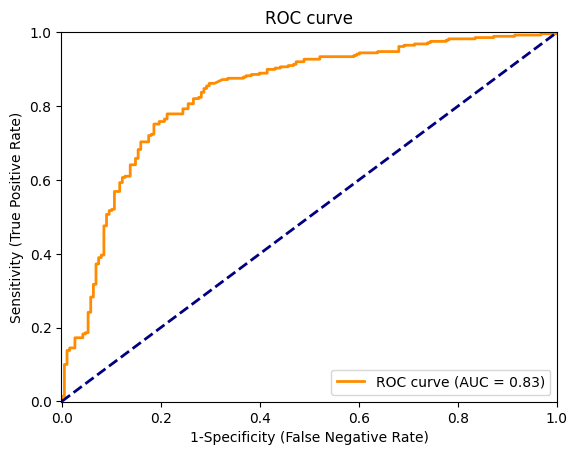

AUC: 0.8333363903154805


In [17]:
from model_metrics import evaluate_model, custom_accuracy_score, custom_sensitivity_score, custom_specificity_score, custom_ppv_score, custom_npv_score, plot_roc

metrics_df = evaluate_model(model,'SVM',X_test, y_test, mean_retention)
all_metrics_df = metrics_df

#### Ajuste (fine / tunning) de hiperparámetros utilizando la función GridSearchCV para maximizar el AUC

In [18]:
steps = [("scaler", StandardScaler()), ('SVM', svm.SVC(probability = True))]
pipeline = Pipeline(steps)

# Selección de la métrica que queremos mejorar
score_func = make_scorer(roc_auc_score, greater_is_better = True)

# Definir la variación de los hiperparametros
param_grid = {'SVM__C': [0.1, 1, 2, 5, 10],
              'SVM__kernel': ['rbf' , 'lineal', 'poly']
            }

# Grid search
grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 5, scoring = score_func, refit = True, verbose = 3, return_train_score = True)
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.695, test=0.639) total time=   3.3s
[CV 2/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.632, test=0.598) total time=   2.2s
[CV 3/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.745, test=0.664) total time=   2.0s
[CV 4/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.629, test=0.570) total time=   1.9s
[CV 5/5] END SVM__C=0.1, SVM__kernel=rbf;, score=(train=0.672, test=0.638) total time=   1.6s
[CV 1/5] END SVM__C=0.1, SVM__kernel=lineal;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END SVM__C=0.1, SVM__kernel=lineal;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END SVM__C=0.1, SVM__kernel=lineal;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END SVM__C=0.1, SVM__kernel=lineal;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END SVM__C=0.1, SVM__kernel=lineal;, score=(train=nan, test=nan) total time=   0.0s
[CV 

In [19]:
# Extraer los resultados del Grid Search
results = grid.cv_results_

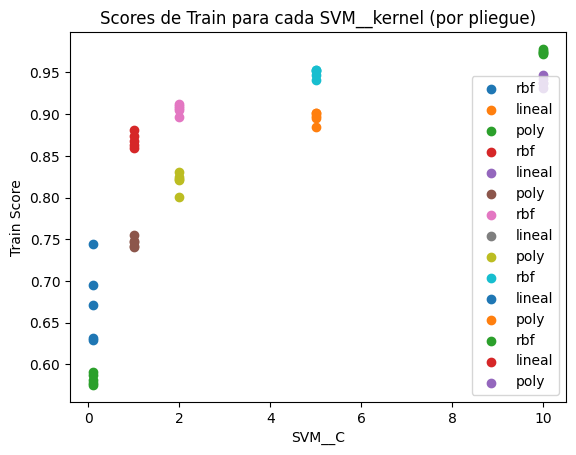

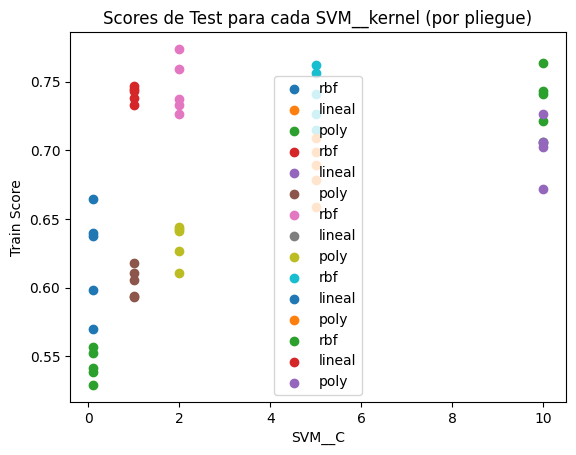

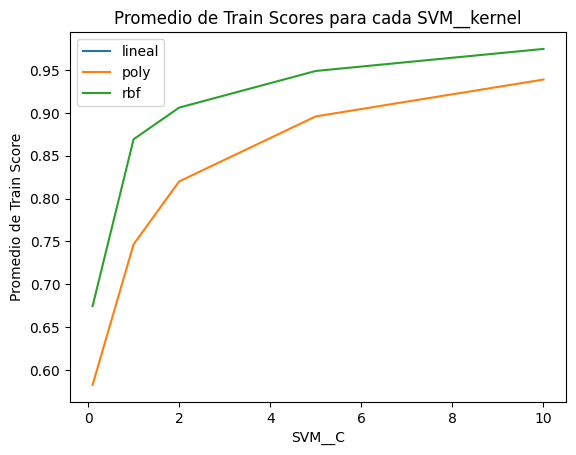

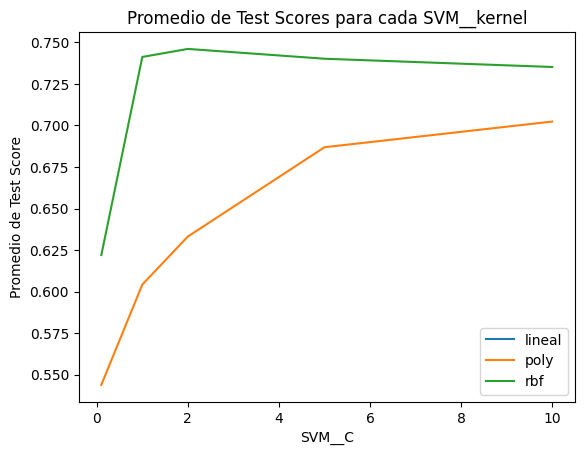

In [20]:
from scores_plotter import ScoresPlotter  # Importa la clase ScoresPlotter desde el archivo scores_plotter.py

# Crear una instancia de ScoresPlotter
plotter = ScoresPlotter(results)

# Llamar al método para graficar los resultados de entrenamiento
plotter.plot_train_scores()

# Llamar al método para graficar los resultados promedio de entrenamiento
plotter.plot_average_train_scores()

# Llamar al método para graficar los resultados promedio de prueba
plotter.plot_average_test_scores()

In [21]:
print(grid.best_params_)
print(grid.best_estimator_)

{'SVM__C': 2, 'SVM__kernel': 'rbf'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('SVM', SVC(C=2, probability=True))])


In [22]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73       188
         1.0       0.81      0.86      0.84       290

    accuracy                           0.80       478
   macro avg       0.79      0.78      0.78       478
weighted avg       0.80      0.80      0.80       478



#### Exportar las predicciones del modelo para su uso posterior

In [23]:
# Predecir
X_pred = X_test
y_pred_prob = grid.predict_proba(X_pred)[:,1]

# Agregr ID
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob})

# Exportar prediciones
Prediction.to_csv("Predicted Retention Probability_testing_SVM.csv",sep = ',')

### 3.3. Modelo 2 - Regresión Logística

#### Generación de Pipeline

In [24]:
# Crear una lista para almacenar los pasos del proceso de modelado de regresión logística
logistic_estimators = []

# Agregar un paso para estandarizar los datos
logistic_estimators.append(('standardize', StandardScaler()))

# Agregar un paso para definir el modelo de regresión logística
logistic_estimators.append(('logistic_regression', LogisticRegression()))

# Crear un objeto Pipeline para encadenar los pasos de procesamiento y modelado
model = Pipeline(logistic_estimators)

# Entrenar el modelo de regresión logística utilizando los datos de entrenamiento
model.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('logistic_regression', LogisticRegression())])

#### Cross Validation

In [25]:
cv = CrossValidation(model)
mean_accuracy, std_accuracy = cv.validate(X, y)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.7165978088295922
Standard Deviation of Accuracy: 0.054475795850288104


#### Obtención de Métricas del modelo usando el archivo *models_metrics.py*
Seleccionar el valor del umbral (Threshold), predecir las clases y calcular las probabilidades y evaluar el rendimiento del modelo.


Metrics of the model:
Confusion matrix:
 [[140  54]
 [ 48 236]]
Accuracy: 0.7866108786610879
Sensitivity (Recall): 0.8137931034482758
Specificity (Fall-Out): 0.7446808510638298
Positive Predictive Value (Precision): 0.8309859154929577
Negative Predictive Value: 0.7216494845360825


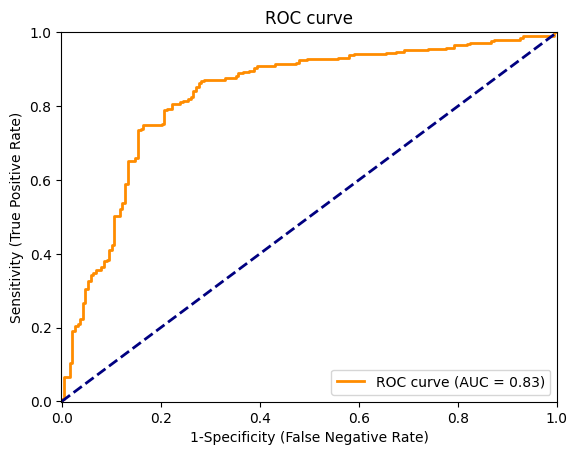

AUC: 0.831639765223771


In [26]:
metrics_df = evaluate_model(model,'Regresión Logística',X_test, y_test, mean_retention)

global all_metrics_df
all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

#### Ajuste (fine / tunning) de hiperparámetros utilizando la función GridSearchCV para maximizar el AUC

In [27]:
# Definir los pasos del pipeline
steps = [("scaler", StandardScaler()), ('logistic_regression', LogisticRegression())]

# Crear el pipeline
pipeline = Pipeline(steps)

# Selección de la métrica que queremos mejorar
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# Definir la variación de los hiperparámetros
param_grid = {'logistic_regression__C': [0.1, 1, 2, 5, 10], 'logistic_regression__penalty': ['l1', 'l2']}

# Grid search
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=score_func, refit=True, verbose=3, return_train_score=True)

# Ajustar el grid search a los datos de entrenamiento
grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END logistic_regression__C=0.1, logistic_regression__penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END logistic_regression__C=0.1, logistic_regression__penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END logistic_regression__C=0.1, logistic_regression__penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END logistic_regression__C=0.1, logistic_regression__penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END logistic_regression__C=0.1, logistic_regression__penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END logistic_regression__C=0.1, logistic_regression__penalty=l2;, score=(train=0.812, test=0.760) total time=   0.1s
[CV 2/5] END logistic_regression__C=0.1, logistic_regression__penalty=l2;, score=(train=0.807, test=0.780) total time=   0.1s
[CV 3/5] END logistic_regression__C=0.1, logistic_regression__penalty=l2;, sc

In [28]:
 # Extraer los resultados del Grid Search
results = grid.cv_results_

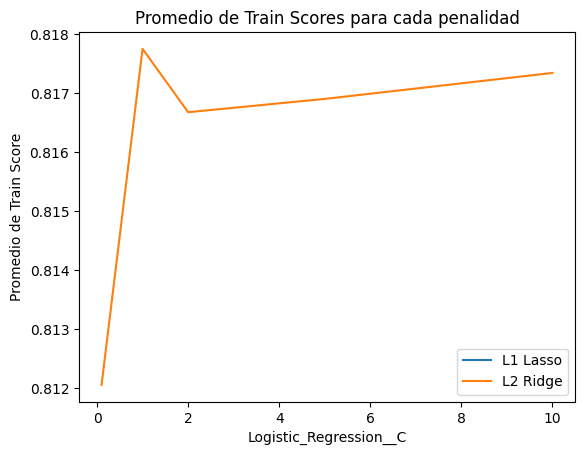

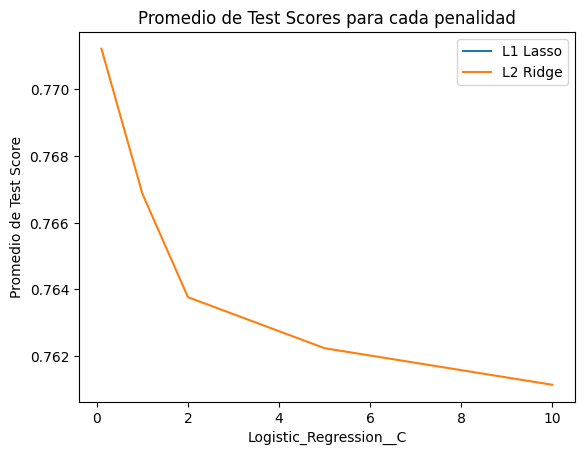

In [29]:
from scores_plotter import LogisticRegressionResultsVisualizer  # Importa la clase ScoresPlotter desde el archivo scores_plotter.py

visualizer = LogisticRegressionResultsVisualizer(results)
visualizer.plot_train_scores()
visualizer.plot_test_scores()

In [30]:
print(grid.best_params_)
print(grid.best_estimator_)

{'logistic_regression__C': 0.1, 'logistic_regression__penalty': 'l2'}
Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(C=0.1))])


In [31]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74       188
         1.0       0.82      0.88      0.85       290

    accuracy                           0.81       478
   macro avg       0.80      0.79      0.79       478
weighted avg       0.80      0.81      0.80       478



#### Exportar las predicciones del modelo para su uso posterior

In [32]:
# Predecir
X_pred = X_test
y_pred_prob = grid.predict_proba(X_pred)[:,1]

# Agregr ID
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob})

# Exportar prediciones
Prediction.to_csv("Predicted Retention Probability_testing_Logistic_Regression.csv",sep = ',')

### 3.4. Modelo 3 - KNN Vecinos mas cercanos

#### Generación de Pipeline

In [33]:
# Lista para almacenar los estimadores del modelo KNN
knn_estimators = []

# Se agrega un paso llamado 'standardize' a la lista knn_estimators. Este paso utiliza StandardScaler() de scikit-learn para estandarizar (escalar)
# los datos, lo que es comúnmente recomendado antes de entrenar un modelo de KNN.
knn_estimators.append(('standardize', StandardScaler())) # Escalar los datos

# Se agrega otro paso llamado 'KNN' a la lista knn_estimators. En este paso, se define el clasificador de KNN utilizando KNeighborsClassifier().
knn_estimators.append(('KNN', KNeighborsClassifier())) # Definir KNN

# Se crea un objeto Pipeline llamado model_KNN utilizando la lista knn_estimators.
# Un Pipeline en scikit-learn se utiliza para encadenar múltiples pasos de procesamiento y modelado en un solo objeto.
model = Pipeline(knn_estimators) # Define el modelo KNN

# Se entrena el modelo model_KNN utilizando el método fit, pasando los conjuntos de entrenamiento X_train e y_train.
model.fit(X_train, y_train) # Entrenar el modelo KNN en los datos de entrenamiento


Pipeline(steps=[('standardize', StandardScaler()),
                ('KNN', KNeighborsClassifier())])

#### Cross Validation

In [34]:
cv = CrossValidation(model)
mean_accuracy, std_accuracy = cv.validate(X, y)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.6668166627194021
Standard Deviation of Accuracy: 0.02710568115034159


#### Obtención de Métricas del modelo usando el archivo *models_metrics.py*
Seleccionar el valor del umbral (Threshold), predecir las clases y calcular las probabilidades y evaluar el rendimiento del modelo.


Metrics of the model:
Confusion matrix:
 [[136 127]
 [ 52 163]]
Accuracy: 0.6255230125523012
Sensitivity (Recall): 0.5620689655172414
Specificity (Fall-Out): 0.723404255319149
Positive Predictive Value (Precision): 0.7581395348837209
Negative Predictive Value: 0.5171102661596958


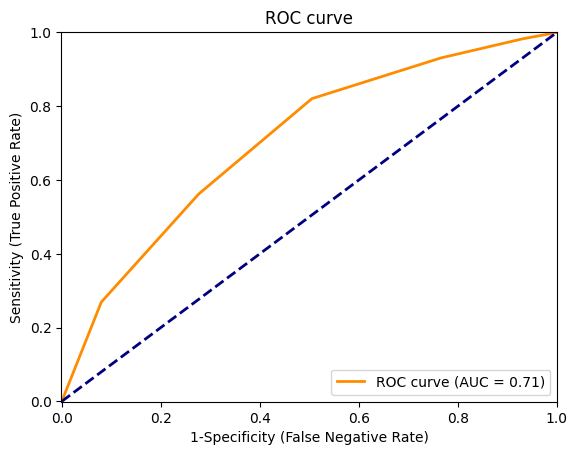

AUC: 0.7052641232575202


In [35]:
metrics_df = evaluate_model(model,'KNN',X_test, y_test, mean_retention)
global all_metrics_df
all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

#### Ajuste (fine / tunning) de hiperparámetros utilizando la función GridSearchCV para maximizar el AUC

In [36]:
steps = [("scaler", StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)
param_grid = {'knn__n_neighbors': [3, 5, 7], 'knn__metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3, return_train_score=True)
grid_search = grid.fit(X_train, y_train)
results = grid.cv_results_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=3;, score=(train=0.912, test=0.734) total time=   0.0s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=3;, score=(train=0.905, test=0.692) total time=   0.0s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=3;, score=(train=0.913, test=0.675) total time=   0.0s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=3;, score=(train=0.915, test=0.692) total time=   0.0s
[CV 5/5] END knn__metric=euclidean, knn__n_neighbors=3;, score=(train=0.907, test=0.732) total time=   0.0s
[CV 1/5] END knn__metric=euclidean, knn__n_neighbors=5;, score=(train=0.880, test=0.748) total time=   0.0s
[CV 2/5] END knn__metric=euclidean, knn__n_neighbors=5;, score=(train=0.874, test=0.711) total time=   0.0s
[CV 3/5] END knn__metric=euclidean, knn__n_neighbors=5;, score=(train=0.881, test=0.697) total time=   0.0s
[CV 4/5] END knn__metric=euclidean, knn__n_neighbors=5;, score=(train=0.878,

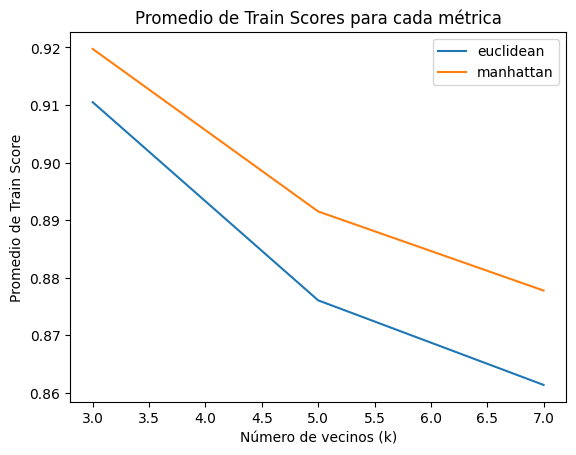

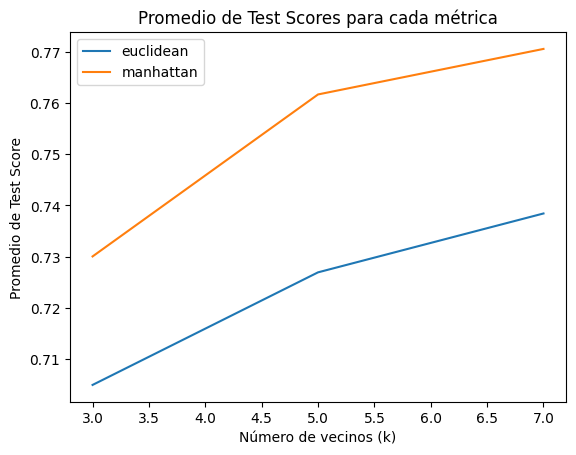

In [37]:
from scores_plotter import KNNResultsVisualizer

# Uso de la clase
visualizer = KNNResultsVisualizer(results)
visualizer.plot_train_scores()
visualizer.plot_test_scores()

In [38]:
print(grid.best_params_)
print(grid.best_estimator_)

{'knn__metric': 'manhattan', 'knn__n_neighbors': 7}
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7))])


In [39]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.70      0.54      0.61       188
         1.0       0.74      0.85      0.79       290

    accuracy                           0.73       478
   macro avg       0.72      0.69      0.70       478
weighted avg       0.72      0.73      0.72       478



#### Exportar las predicciones del modelo para su uso posterior

In [40]:
# Predecir
X_pred = X_test
y_pred_prob = grid.predict_proba(X_pred)[:,1]

# Agregr ID
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob})

# Exportar prediciones
Prediction.to_csv("Predicted Retention Probability_testing_KNN.csv",sep = ',')

### 3.5. Modelo 4 - Random Forest

#### Generación de Pipeline

In [41]:
# Lista para almacenar los estimadores del modelo Random Forest
rf_estimators = []

# Se agrega un paso llamado 'standardize' a la lista rf_estimators. Este paso utiliza StandardScaler() de scikit-learn para estandarizar (escalar)
# los datos, lo que es comúnmente recomendado antes de entrenar un modelo.
rf_estimators.append(('standardize', StandardScaler())) # Escalar los datos

# Se agrega otro paso llamado 'RandomForest' a la lista rf_estimators. En este paso, se define el clasificador de Random Forest utilizando RandomForestClassifier().
rf_estimators.append(('RandomForest', RandomForestClassifier())) # Definir Random Forest

# Se crea un objeto Pipeline llamado model_RF utilizando la lista rf_estimators.
# Un Pipeline en scikit-learn se utiliza para encadenar múltiples pasos de procesamiento y modelado en un solo objeto.
model = Pipeline(rf_estimators) # Define el modelo Random Forest

# Se entrena el modelo model_RF utilizando el método fit, pasando los conjuntos de entrenamiento X_train e y_train.
model.fit(X_train, y_train) # Entrenar el modelo Random Forest en los datos de entrenamiento


Pipeline(steps=[('standardize', StandardScaler()),
                ('RandomForest', RandomForestClassifier())])

#### Cross Validation

In [42]:
cv = CrossValidation(model)
mean_accuracy, std_accuracy = cv.validate(X, y)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.7173723498504426
Standard Deviation of Accuracy: 0.10232859005227836


#### Obtención de Métricas del modelo usando el archivo *models_metrics.py*
Seleccionar el valor del umbral (Threshold), predecir las clases y calcular las probabilidades y evaluar el rendimiento del modelo.


Metrics of the model:
Confusion matrix:
 [[159  71]
 [ 29 219]]
Accuracy: 0.7907949790794979
Sensitivity (Recall): 0.7551724137931034
Specificity (Fall-Out): 0.8457446808510638
Positive Predictive Value (Precision): 0.8830645161290323
Negative Predictive Value: 0.691304347826087


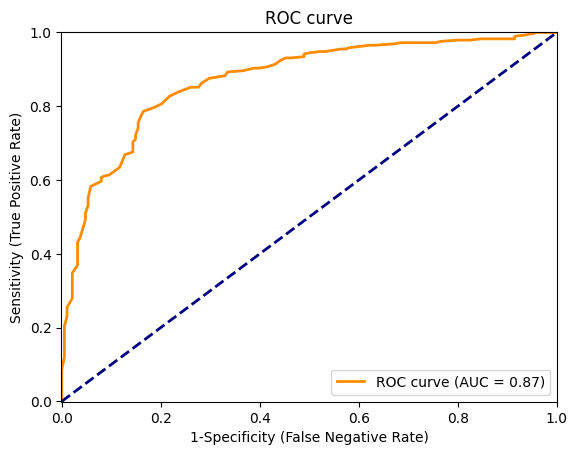

AUC: 0.8715608950843726


In [43]:
metrics_df = evaluate_model(model,'Random Forest',X_test, y_test, mean_retention)
global all_metrics_df
all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

#### Ajuste (fine / tunning) de hiperparámetros utilizando la función GridSearchCV para maximizar el AUC

In [44]:
# Definir los pasos del Pipeline
steps = [("scaler", StandardScaler()), ('RandomForest', RandomForestClassifier())]
pipeline_rf = Pipeline(steps)

# Selección de la métrica que queremos mejorar
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# Definir la variación de los hiperparámetros
param_grid = {'RandomForest__n_estimators': [100, 200, 300],
              'RandomForest__max_depth': [None, 10, 20],
              'RandomForest__min_samples_split': [2, 5, 10],
              'RandomForest__min_samples_leaf': [1, 2, 4]
            }

# Grid search
grid_rf = GridSearchCV(pipeline_rf, param_grid=param_grid, cv=5, scoring=score_func, refit=True, verbose=3, return_train_score=True)
grid_search_rf = grid_rf.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END RandomForest__max_depth=None, RandomForest__min_samples_leaf=1, RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=(train=1.000, test=0.786) total time=   0.5s
[CV 2/5] END RandomForest__max_depth=None, RandomForest__min_samples_leaf=1, RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=(train=1.000, test=0.785) total time=   0.5s
[CV 3/5] END RandomForest__max_depth=None, RandomForest__min_samples_leaf=1, RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=(train=1.000, test=0.717) total time=   0.6s
[CV 4/5] END RandomForest__max_depth=None, RandomForest__min_samples_leaf=1, RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=(train=1.000, test=0.787) total time=   0.8s
[CV 5/5] END RandomForest__max_depth=None, RandomForest__min_samples_leaf=1, RandomForest__min_samples_split=2, RandomForest__n_estimators=100;, score=(tr

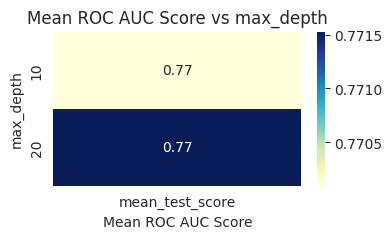

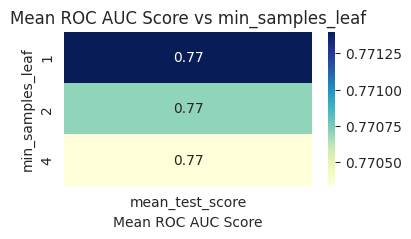

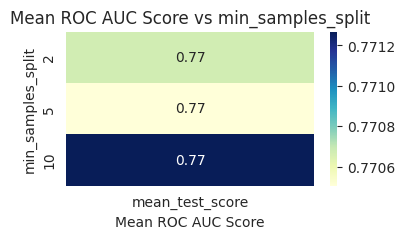

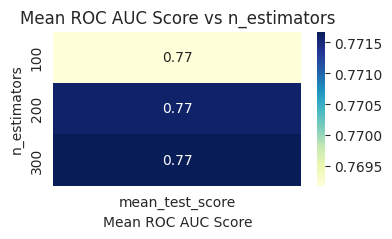

In [45]:
# Obtener los resultados de la búsqueda de hiperparámetros
results = pd.DataFrame(grid_search_rf.cv_results_)

# Extraer los nombres de las columnas relacionadas con los hiperparámetros
param_columns = [col for col in results.columns if 'param_' in col]

# Crear una lista de los hiperparámetros y sus valores
param_values = [grid_search_rf.cv_results_[param].data for param in param_columns]

# Crear una lista de los nombres de los hiperparámetros
param_names = [param.split('__')[-1] for param in param_columns]

# Combinar los nombres y los valores de los hiperparámetros en un DataFrame
params_df = pd.DataFrame(np.transpose(param_values), columns=param_names)

# Agregar las columnas de la métrica de desempeño y el tiempo de ajuste
params_df['mean_test_score'] = results['mean_test_score']
params_df['std_test_score'] = results['std_test_score']
params_df['mean_fit_time'] = results['mean_fit_time']
params_df['std_fit_time'] = results['std_fit_time']

# Graficar los resultados para cada combinación de hiperparámetros
for param in param_names:
    sns.set_style("whitegrid")
    plt.figure(figsize=(4,2))
    sns.heatmap(params_df.pivot_table(index=param, values='mean_test_score', aggfunc=np.mean).fillna(0), annot=True, cmap="YlGnBu")
    plt.title("Mean ROC AUC Score vs {}".format(param))
    plt.ylabel(param)
    plt.xlabel("Mean ROC AUC Score")
    plt.show()


In [46]:
rf_best_params = grid_rf.best_params_
rf_best_estimator = grid_rf.best_estimator_

print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

{'RandomForest__max_depth': None, 'RandomForest__min_samples_leaf': 1, 'RandomForest__min_samples_split': 10, 'RandomForest__n_estimators': 100}
Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForest', RandomForestClassifier(min_samples_split=10))])


In [47]:
grid_rf_predictions = grid_rf.predict(X_test)
print(classification_report(y_test, grid_rf_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.72      0.75       188
         1.0       0.83      0.87      0.85       290

    accuracy                           0.81       478
   macro avg       0.81      0.80      0.80       478
weighted avg       0.81      0.81      0.81       478



#### Exportar las predicciones del modelo para su uso posterior

In [48]:
# Predecir
X_pred = X_test
y_pred_prob = grid_rf.predict_proba(X_pred)[:,1]

# Agregr ID
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob})

# Exportar prediciones
Prediction.to_csv("Predicted Retention Probability_testing_Random_Forest.csv",sep = ',')

### 3.6. Modelo 5 - AdaBoost

#### Generación de Pipeline

In [49]:
# Almacenar los pasos del proceso de modelado de AdaBoost.
adaboost_estimators = []

# Se agrega un paso llamado 'standardize' a la lista adaboost_estimators. Este paso utiliza StandardScaler() de scikit-learn para estandarizar (escalar)
# los datos, lo que es comúnmente recomendado antes de entrenar un modelo de AdaBoost.

adaboost_estimators.append(('standardize', StandardScaler())) # escalar los datos

# Se agrega otro paso llamado 'AdaBoost' a la lista adaboost_estimators. En este paso, se define el clasificador AdaBoost utilizando AdaBoostClassifier().
adaboost_estimators.append(('AdaBoost', AdaBoostClassifier())) # define AdaBoost

# Se crea un objeto Pipeline llamado model utilizando la lista adaboost_estimators.
# Un Pipeline en scikit-learn se utiliza para encadenar múltiples pasos de procesamiento y modelado en un solo objeto.
model = Pipeline(adaboost_estimators, verbose=False) # Define el modelo AdaBoost

# El modelo se entrena utilizando el método fit, pasando los conjuntos de entrenamiento X_train e y_train.
model.fit(X_train, y_train) # Entrenar el modelo en los datos de entrenamiento


Pipeline(steps=[('standardize', StandardScaler()),
                ('AdaBoost', AdaBoostClassifier())])

#### Cross Validation

In [50]:
cv = CrossValidation(model)
mean_accuracy, std_accuracy = cv.validate(X, y)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)

Mean Accuracy: 0.5294536108698894
Standard Deviation of Accuracy: 0.13498146391304994


#### Obtención de Métricas del modelo usando el archivo *models_metrics.py*
Seleccionar el valor del umbral (Threshold), predecir las clases y calcular las probabilidades y evaluar el rendimiento del modelo.


Metrics of the model:
Confusion matrix:
 [[186 286]
 [  2   4]]
Accuracy: 0.39748953974895396
Sensitivity (Recall): 0.013793103448275862
Specificity (Fall-Out): 0.9893617021276596
Positive Predictive Value (Precision): 0.6666666666666666
Negative Predictive Value: 0.3940677966101695


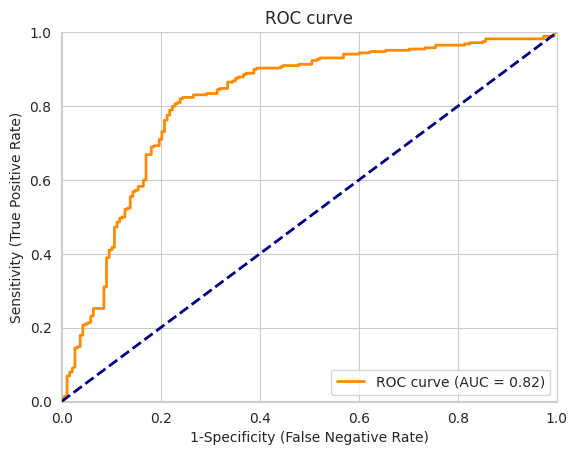

AUC: 0.815581438004402


In [51]:
metrics_df = evaluate_model(model,'AdaBoost',X_test, y_test, mean_retention)
global all_metrics_df
all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

#### Ajuste (fine / tunning) de hiperparámetros utilizando la función GridSearchCV para maximizar el AUC

In [52]:
# Definir el pipeline
steps = [("scaler", StandardScaler()), ('AdaBoost', AdaBoostClassifier())]
pipeline = Pipeline(steps)

# Selección de la métrica que queremos mejorar
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# Definir la variación de los hiperparámetros
param_grid = {'AdaBoost__n_estimators': [50, 100, 200],
              'AdaBoost__learning_rate': [0.01, 0.1, 1, 2]}

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid search
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=score_func, refit=True, verbose=3, return_train_score=True)
grid_search = grid.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=50;, score=(train=0.732, test=0.743) total time=   0.4s
[CV 2/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=50;, score=(train=0.727, test=0.765) total time=   0.4s
[CV 3/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=50;, score=(train=0.741, test=0.709) total time=   0.4s
[CV 4/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=50;, score=(train=0.740, test=0.713) total time=   0.4s
[CV 5/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=50;, score=(train=0.732, test=0.741) total time=   0.4s
[CV 1/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=100;, score=(train=0.770, test=0.760) total time=   0.8s
[CV 2/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=100;, score=(train=0.756, test=0.816) total time=   0.7s
[CV 3/5] END AdaBoost__learning_rate=0.01, AdaBoost__n_estimators=100;, score=(trai

In [53]:
# Extraer los resultados del Grid Search
results = grid.cv_results_


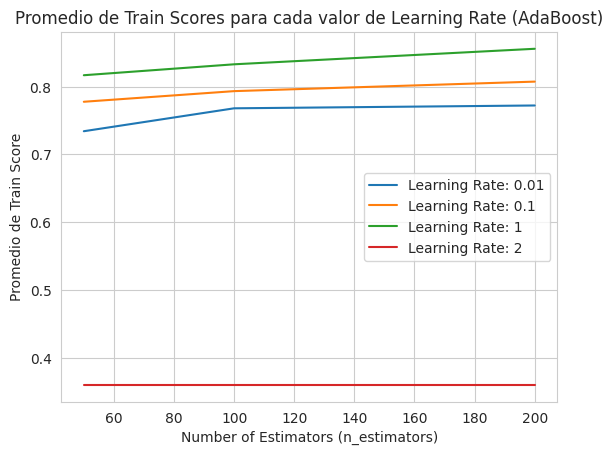

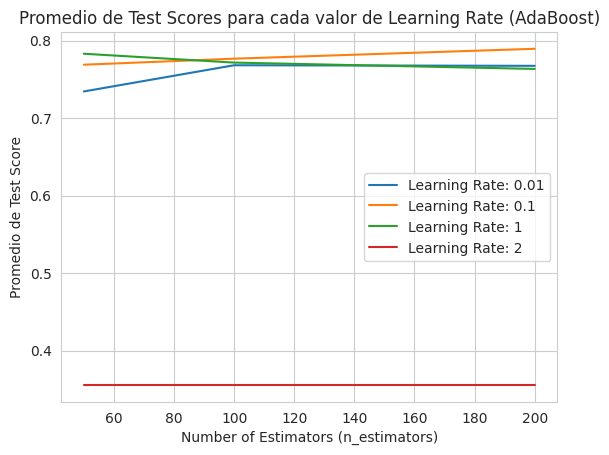

In [54]:
# Obtener los valores de learning_rate y n_estimators
learning_rate_values = np.unique(grid_search.cv_results_['param_AdaBoost__learning_rate'].data)
n_estimators_values = np.unique(grid_search.cv_results_['param_AdaBoost__n_estimators'].data)
train_scores = grid_search.cv_results_['mean_train_score']

# Graficar cada línea para cada combinación de learning_rate
for learning_rate in learning_rate_values:
    learning_rate_scores = train_scores[grid_search.cv_results_['param_AdaBoost__learning_rate'].data == learning_rate]
    plt.plot(n_estimators_values, learning_rate_scores, label=f'Learning Rate: {learning_rate}')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Promedio de Train Score')
plt.title('Promedio de Train Scores para cada valor de Learning Rate (AdaBoost)')
plt.legend()
plt.show()



# Obtener los valores de learning_rate y n_estimators
learning_rate_values = np.unique(grid_search.cv_results_['param_AdaBoost__learning_rate'].data)
n_estimators_values = np.unique(grid_search.cv_results_['param_AdaBoost__n_estimators'].data)
test_scores = grid_search.cv_results_['mean_test_score']

# Graficar cada línea para cada combinación de learning_rate
for learning_rate in learning_rate_values:
    learning_rate_scores = test_scores[grid_search.cv_results_['param_AdaBoost__learning_rate'].data == learning_rate]
    plt.plot(n_estimators_values, learning_rate_scores, label=f'Learning Rate: {learning_rate}')

plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Promedio de Test Score')
plt.title('Promedio de Test Scores para cada valor de Learning Rate (AdaBoost)')
plt.legend()
plt.show()


In [55]:
print(grid.best_params_)
print(grid.best_estimator_)

{'AdaBoost__learning_rate': 0.1, 'AdaBoost__n_estimators': 200}
Pipeline(steps=[('scaler', StandardScaler()),
                ('AdaBoost',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=200))])


In [56]:
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72       204
         1.0       0.78      0.86      0.82       274

    accuracy                           0.78       478
   macro avg       0.78      0.76      0.77       478
weighted avg       0.78      0.78      0.78       478



#### Exportar las predicciones del modelo para su uso posterior

In [57]:
# Predecir
X_pred = X_test
y_pred_prob = grid.predict_proba(X_pred)[:,1]

# Agregr ID
Prediction = pd.DataFrame(data={"ID":X_pred["ID"],"Predicted Probability":y_pred_prob})

# Exportar prediciones
Prediction.to_csv("Predicted Retention Probability_testing_AdaBoost.csv",sep = ',')

## **4. Comparación de Resultados**



In [58]:
all_metrics_df

,Model,Accuracy,Sensitivity (Recall),Specificity (Fall-Out),Positive Predictive Value (Precision),Negative Predictive Value,AUC
0,SVM,0.776151,0.789655,0.755319,0.832727,0.699507,0.833336
1,Regresión Logística,0.786611,0.813793,0.744681,0.830986,0.721649,0.831640
2,KNN,0.625523,0.562069,0.723404,0.758140,0.517110,0.705264
3,Random Forest,0.790795,0.755172,0.845745,0.883065,0.691304,0.871561
4,AdaBoost,0.397490,0.013793,0.989362,0.666667,0.394068,0.815581


#### Mejor Modelo

In [59]:
# Calcular el puntaje combinado como el promedio ponderado del Accuracy y el AUC
all_metrics_df['Combined_Score'] = 0.5 * all_metrics_df['Accuracy'] + 0.5 * all_metrics_df['AUC']

# Encontrar el modelo con el puntaje combinado más alto
best_model = all_metrics_df.loc[all_metrics_df['Combined_Score'].idxmax(), 'Model']

print("El mejor modelo basado en el puntaje combinado (Accuracy + AUC) es:", best_model)

El mejor modelo basado en el puntaje combinado (Accuracy + AUC) es: Random Forest


### Exportar mejor modelo

In [60]:
# Paso 1: Definición de los hiperparametros del Modelo Final
modelo_final = pipeline_rf.set_params(**grid_search_rf.best_params_)
modelo_final.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('RandomForest', RandomForestClassifier(min_samples_split=10))])

In [61]:
# Paso 2: Almacenar modelo Final en un archivo (Serialización)
from joblib import dump # libreria de serializacion

# grabar el pipeline de las transformaciones y el mejor modelo en un archivo .joblib
dump(modelo_final, 'modelo_final.joblib')

['modelo_final.joblib']

## **5. Análisis usando Pycaret**

In [1]:
!pip install pycaret

In [2]:
# Paso 1: Importar las bibliotecas necesarias
import pandas as pd
from pycaret.regression import *

# Paso 2: Cargar los datos
data = pd.read_csv('03 CSV data -- STC(A)_numerical dates.csv')

In [3]:
# Paso 3: Configurar PyCaret
# En este paso, inicializamos la configuración de PyCaret con los parámetros necesarios
# Se puede ajustar el parámetro 'target' con el nombre de la columna que representa la variable objetivo en tu conjunto de datos
exp_reg = setup(data, target='Retained.in.2012.', session_id=123)

,Description,Value
0,Session id,123
1,Target,Retained.in.2012.
2,Target type,Regression
3,Original data shape,"(2389, 56)"
4,Transformed data shape,"(2389, 156)"
5,Transformed train set shape,"(1672, 156)"
6,Transformed test set shape,"(717, 156)"
7,Numeric features,35
8,Categorical features,20
9,Rows with missing values,92.0%


In [4]:
# Paso 5: Entrenar y comparar modelos
# En esta etapa, entrenamos varios modelos y los comparamos utilizando validación cruzada
# PyCaret automáticamente seleccionará los mejores modelos para cada algoritmo y los comparará
best_model = compare_models(fold=5, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2828,0.1415,0.3755,0.4063,0.2626,0.2346,1.6880
rf,Random Forest Regressor,0.2830,0.1471,0.3828,0.3827,0.2670,0.2374,2.9440
br,Bayesian Ridge,0.3089,0.1479,0.3844,0.3787,0.2684,0.2582,0.5000
ada,AdaBoost Regressor,0.3333,0.1525,0.3903,0.3599,0.2717,0.3008,0.5700
lightgbm,Light Gradient Boosting Machine,0.2898,0.1537,0.3914,0.3552,0.2705,0.2491,1.2440
ridge,Ridge Regression,0.3067,0.1542,0.3923,0.3528,0.2720,0.2557,2.0400
et,Extra Trees Regressor,0.2699,0.1574,0.3962,0.3392,0.2752,0.2266,2.5540
xgboost,Extreme Gradient Boosting,0.2936,0.1665,0.4077,0.3008,0.2787,0.2484,1.0900
omp,Orthogonal Matching Pursuit,0.3774,0.1858,0.4307,0.2204,0.3013,0.3141,1.0180
huber,Huber Regressor,0.4314,0.2129,0.4613,0.1053,0.3228,0.3623,0.7180


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
print(best_model)

GradientBoostingRegressor(random_state=123)


In [6]:
# Paso 6: Ajustar hiperparámetros del mejor modelo
# Utilizamos el mejor modelo obtenido en el paso anterior y ajustamos sus hiperparámetros
tuned_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3203,0.1919,0.4381,0.1954,0.3018,0.2747
1,0.2996,0.1647,0.4058,0.3379,0.2869,0.2226
2,0.2904,0.1580,0.3975,0.3482,0.2794,0.2285
3,0.2829,0.1538,0.3921,0.3532,0.2663,0.2670
4,0.2798,0.1499,0.3872,0.3728,0.2685,0.2462
5,0.2793,0.1639,0.4049,0.3104,0.2813,0.2351
6,0.2570,0.1255,0.3542,0.4692,0.2490,0.2019
7,0.2709,0.1391,0.3730,0.4262,0.2563,0.2574
8,0.2759,0.1474,0.3839,0.3443,0.2655,0.2180


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [7]:
# Paso 7: Finalizar el modelo
# En esta etapa, finalizamos el modelo seleccionado después del ajuste de hiperparámetros
final_model = finalize_model(tuned_model)

In [8]:
# Paso 8: Guardar el modelo
# Se guarda el modelo entrenado para su uso futuro
save_model(final_model, 'final_model_using_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['ID', 'From.Grade', 'To.Grade',
                                              'Is.Non.Annual.', 'Days',
                                              'Departure.Date', 'Return.Date',
                                              'Deposit.Date', 'Tuition',
                                              'FRP.Active', 'FRP.Cancelled',
                                              'FRP.Take.up.percent.',
                                              'Early.RPL', 'Latest.RPL',
                                              'Cancelled.Pax',
                                              'Total.Discount.Pax',
                                              'Initial.System.Date',
                                              'CRM.Segmen...
                                                               handle_missing='return_nan',
                                              